In [800]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "27" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 126
repetitionName = "udrlV1cOnlySepOnlyCurr05th" #"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = True
cmbSize = 2
if saveTop:
    saveTopName = "top1udrlv.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)


45
5.0


In [801]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    if len(soloFeatures) < len(subSoloFeatures):
        soloFeatures = subSoloFeatures
    if len(featCombos) < len(subfeatCombos):
        featCombos = subfeatCombos
    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])
#print(combinationDict)
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
                print(ares)
                aC = aResults2[3]
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]

    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

# timesPerCombo = timesPerCombo/len(savedResults)

# combinationResult[:,:,1] = combinationResult[:,:,1] / timesPerCombo


headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            # if res[1]>0.99:
            #     print(res[1])
            #     res[1] = res[1] / 2
            #     print(res[1])
                
            # print(res[0])
            cmbNr = int(res[0])
            # print(cmbNr)
            #print(cmbNr)
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            # print(comboName)
            #print(nameIndex)
            #print(featCombos[nameIndex])
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




0.2916666666666667
0.2916666666666667
0.2916666666666667
0.4583333333333333
0.5
0.5
0.5
0.4583333333333333
0.5
0.5833333333333334
0.5833333333333334
0.5833333333333334
0.4583333333333333
0.5416666666666666
0.4583333333333333
0.5
0.625
0.5416666666666666
0.5833333333333334
0.5833333333333334
0.6666666666666666
0.5
0.4583333333333333
0.5833333333333334
0.375
0.375
0.4166666666666667
0.5416666666666666
0.5416666666666666
0.5
0.5833333333333334
0.5833333333333334
0.5833333333333334
0.5416666666666666
0.5416666666666666
0.4583333333333333
0.5416666666666666
0.5833333333333334
0.5416666666666666
0.6666666666666666
0.6666666666666666
0.6666666666666666
0.5416666666666666
0.5416666666666666
0.6666666666666666
0.4166666666666667
0.3333333333333333
0.4583333333333333
0.5416666666666666
0.5416666666666666
0.5
0.5833333333333334
0.5416666666666666
0.5416666666666666
0.5833333333333334
0.5833333333333334
0.5833333333333334
0.5
0.5
0.5833333333333334
0.5416666666666666
0.5833333333333334
0.5
0.58333

0         1         2         3         4         5         6     \
0       0.0      None      None      None      None      None      None   
1       0.5      0.45      0.49       0.5      0.46      0.43      0.48   
2  0.466667     0.475      0.55  0.558333  0.491667  0.608333      0.65   
3  0.709091  0.663636  0.636364  0.681818  0.718182  0.636364  0.536364   
4     0.475  0.433333  0.483333  0.408333  0.491667  0.408333     0.425   
5  0.583333  0.566667  0.558333     0.675  0.633333      0.65  0.516667   
6       0.4  0.372727  0.390909  0.490909  0.463636  0.509091  0.509091   
7     0.725  0.633333  0.733333  0.583333      0.55  0.591667  0.533333   
8       0.4      0.43      0.43      0.51      0.45      0.52      0.47   
9  0.433333     0.375  0.408333  0.533333       0.5      0.55  0.416667   

       7         8         9         10        11        12        13    \
0      None      None      None      None      None      None      None   
1      0.53      0.48      0.54      0.52      0.52      0.52      0.48   
2  0.608333  0.666667  0.566667  0.508333  0.566667  0.558333  0.558333   
3  0.554545  0.618182  0.627273  0.590909  0.590909  0.618182  0.545455   
4  0.416667  0.441667  0.616667  0.616667     0.625     0.575  0.533333   
5     0.475       0.5     0.475  0.508333  0.433333  0.458333  0.358333   
6  0.472727  0.463636  0.527273  0.572727       0.5  0.590909  0.472727   
7      0.55      0.55  0.508333  0.508333  0.541667  0.441667  0.408333   
8      0.51      0.48      0.44      0.48      0.41      0.42      0.38   
9  0.416667     0.425  0.566667  0.541667  0.558333  0.466667     0.475   

       14        15        16        17        18        19        20    \
0      None      None      None      None      None      None      None   
1      0.55      0.53      0.48       0.5      0.65      0.62      0.65   
2     0.525  0.608333  0.558333  0.616667  0.466667       0.5     0.475   
3  0.590909  0.581818  0.636364  0.554545  0.545455  0.536364  0.563636   
4  0.558333  0.508333      0.55      0.55  0.608333  0.583333  0.591667   
5  0.433333  0.541667     0.525      0.55       0.6  0.533333  0.641667   
6  0.563636  0.481818  0.463636  0.490909  0.472727  0.427273  0.481818   
7  0.441667  0.458333     0.425     0.525  0.458333  0.466667  0.458333   
8      0.48      0.54      0.47      0.61      0.42      0.38      0.39   
9  0.458333  0.616667  0.558333  0.558333  0.516667  0.491667       0.5   

       21        22        23        24        25        26        27    \
0      None      None      None      None      None      None      None   
1      0.53      0.48      0.58      0.53      0.57      0.46      0.58   
2  0.491667  0.458333  0.566667  0.491667  0.483333     0.525       0.6   
3  0.481818  0.418182  0.518182       0.7  0.681818  0.618182  0.681818   
4  0.516667  0.583333  0.466667       0.5  0.466667  0.541667       0.5   
5  0.466667  0.558333  0.466667     0.625  0.566667  0.541667  0.641667   
6       0.5  0.518182  0.518182  0.445455  0.427273  0.481818  0.509091   
7  0.541667      0.55  0.483333  0.708333  0.591667  0.766667  0.566667   
8      0.47      0.46      0.46      0.48      0.45      0.41       0.5   
9  0.566667  0.466667  0.533333  0.458333  0.366667     0.475  0.408333   

       28        29        30        31        32        33        34    \
0      None      None      None      None      None      None      None   
1      0.49      0.52      0.49      0.53      0.51      0.56       0.5   
2     0.525  0.608333  0.608333  0.558333  0.616667  0.533333  0.491667   
3  0.681818  0.609091  0.563636  0.518182  0.527273  0.627273  0.563636   
4  0.508333     0.525  0.558333  0.533333       0.6  0.608333  0.541667   
5  0.583333  0.633333  0.516667  0.491667     0.475  0.508333  0.458333   
6  0.563636  0.518182  0.527273  0.554545  0.545455  0.636364  0.527273   
7      0.55     0.575  0.516667  0.583333  0.558333     0.475  0.441667   
8      0.46      0.52      0

In [802]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


fftDatapeakTime4SortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13  \
0                                           0.000000                                                 
1                                           0.500000                                                 
2                                           0.550000                                                 
3                                           0.709091                                                 
4                                           0.483333                                                 
5                                           0.583333                                                 
6                                           0.400000                                                 
7                                           0.733333                                                 
8                                           0.430000                                                 
9                                           0.433333                                                 

   fftDatapeakTime4SortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13  \
0                                           0.000000                                                   
1                                           0.500000                                                   
2                                           0.608333                                                   
3                                           0.718182                                                   
4                                           0.491667                                                   
5                                           0.675000                                                   
6                                           0.509091                                                   
7                                           0.591667                                                   
8                                           0.520000                                                   
9                                           0.550000                                                   

   fftDatapeakTime4SortedSep13_&_gausData_BClateTimeSortedSep13_&_fftData_BClateTimeSortedSep13  \
0                                           0.000000                                              
1                                           0.530000                                              
2                                           0.666667                                              
3                                           0.618182                                              
4                                           0.441667                                              
5                                           0.516667                                              
6                                           0.509091                                              
7                                           0.550000                                              
8                                           0.510000                                              
9                                           0.425000                                              

   fftDatapeakTime4SortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13  \
0                                           0.000000                                                    
1                                           0.540000                                                    
2                                           0.566667                                                    
3                                           0.627273                                                    
4                                           0.625000                                                    
5              

In [803]:
for x in timesPerCombo:
    print(x)

45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0
45.0


(486,)




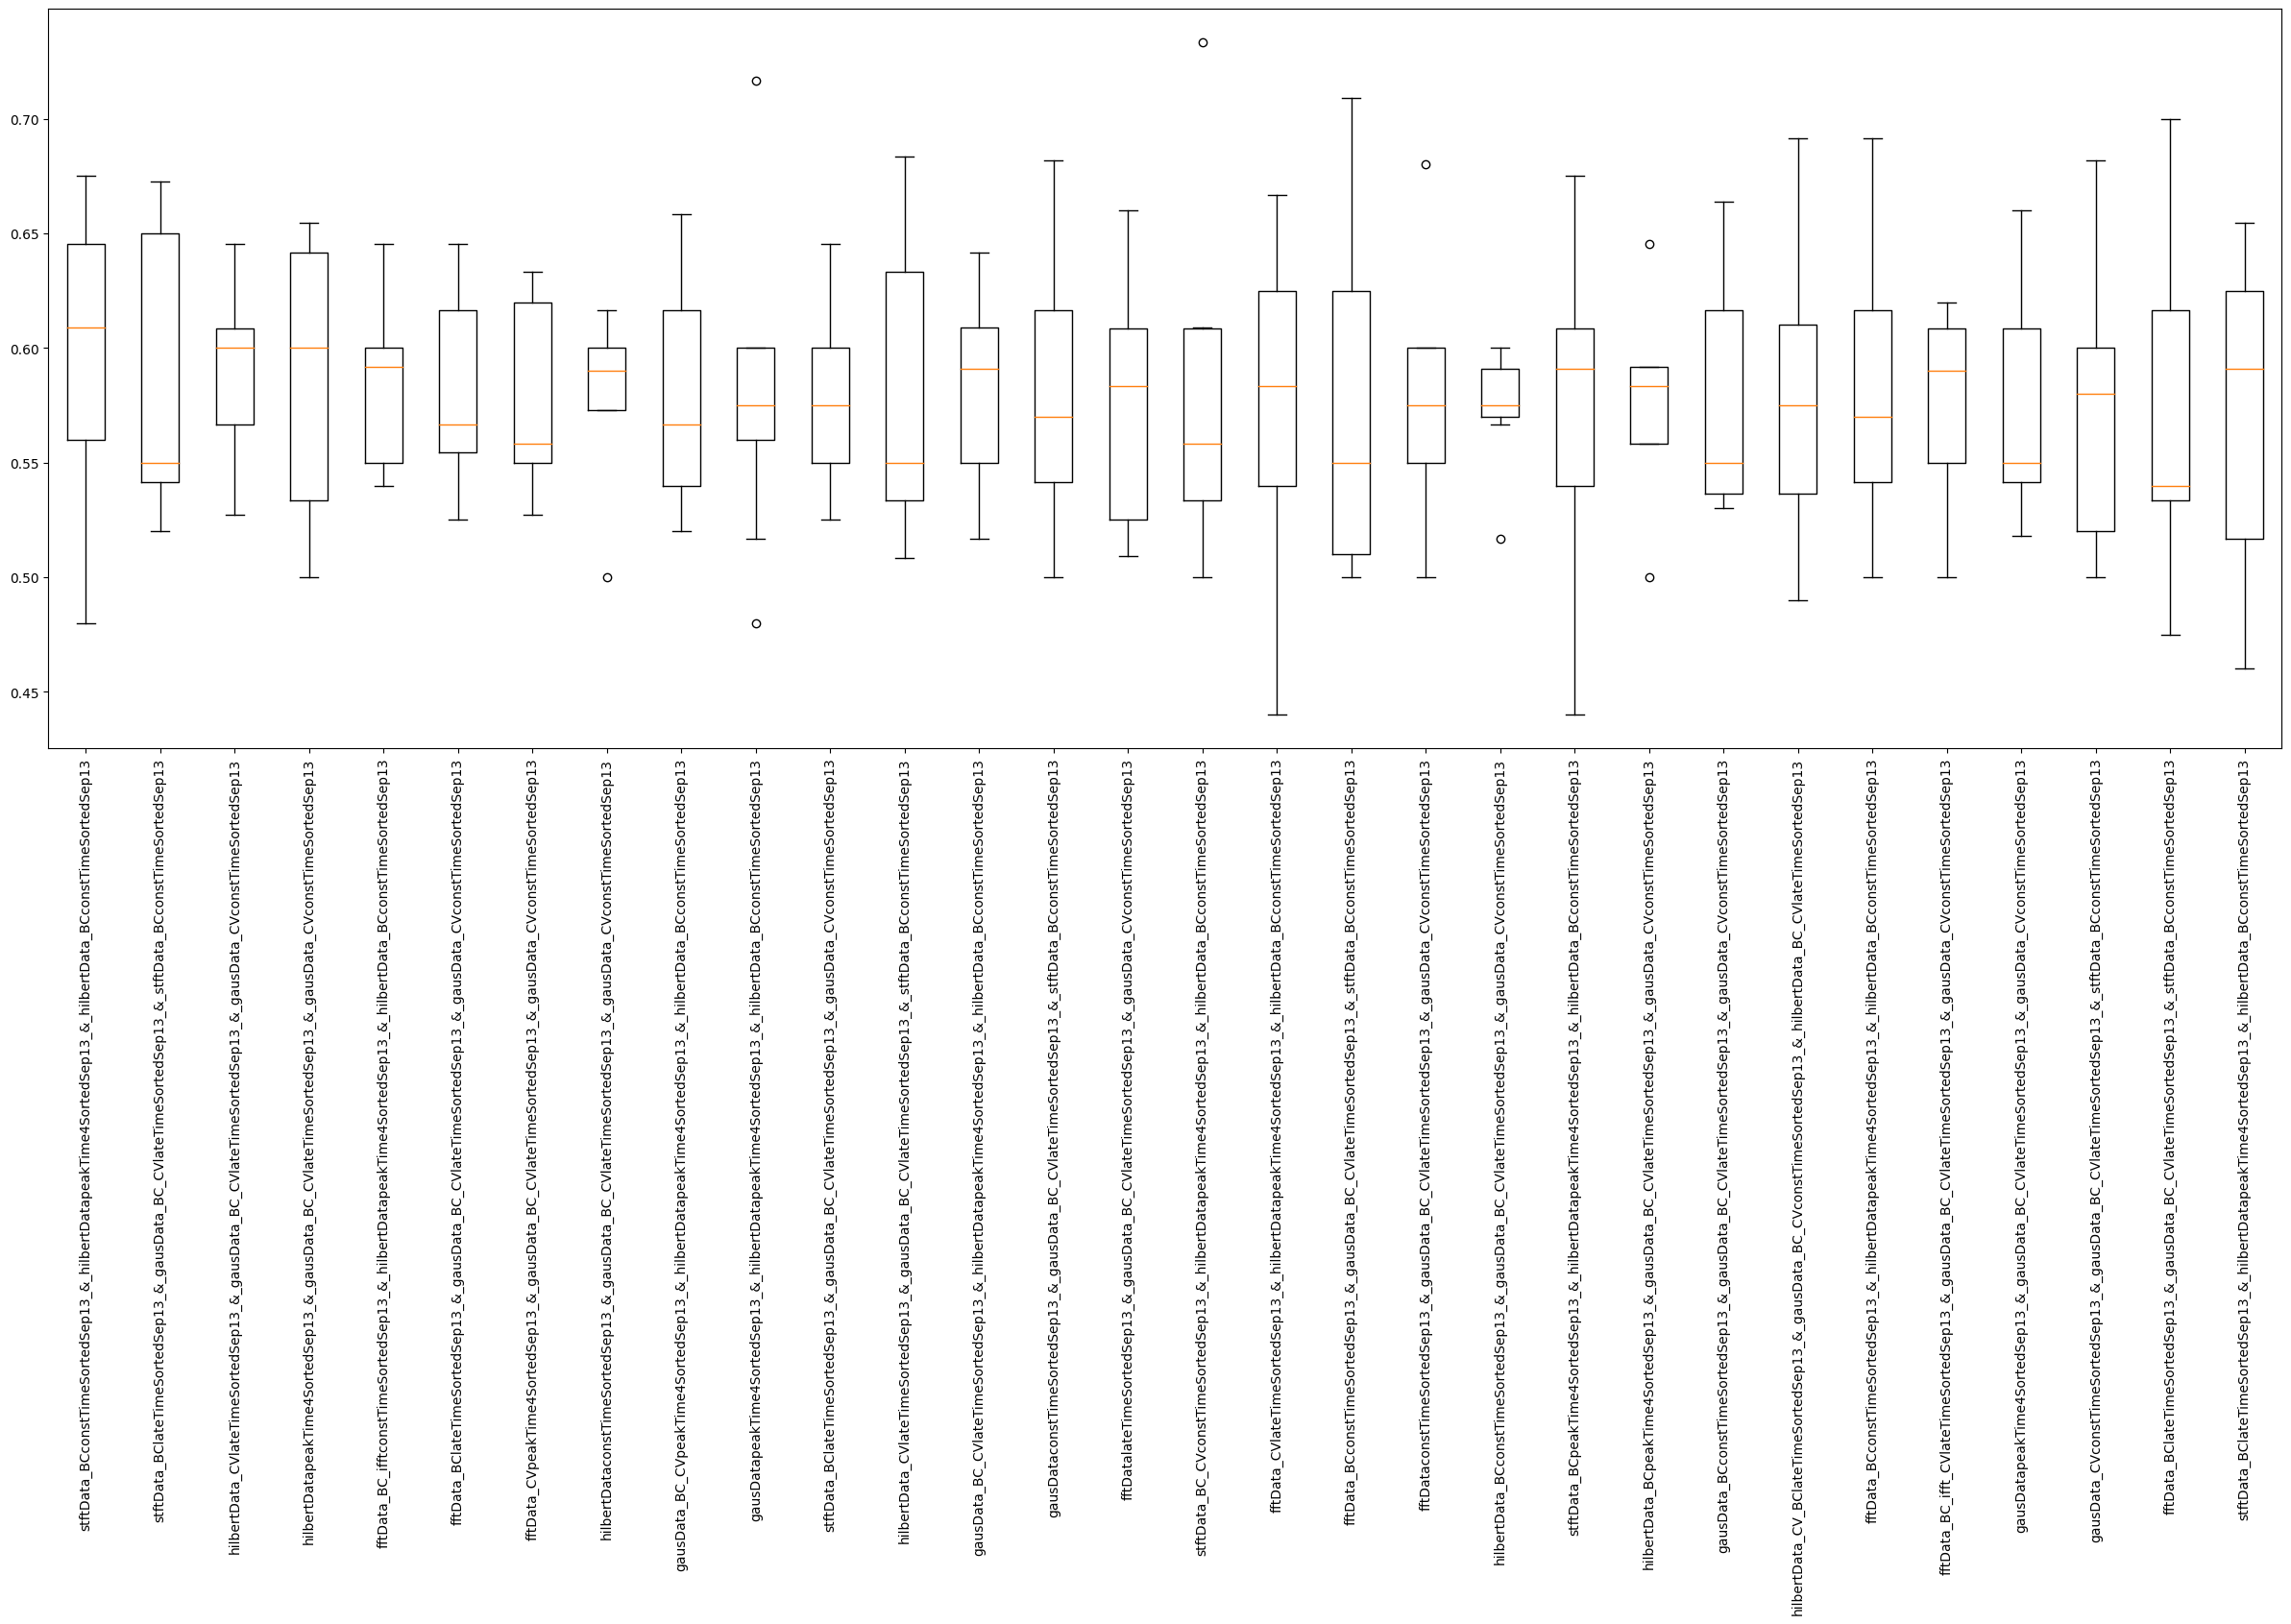

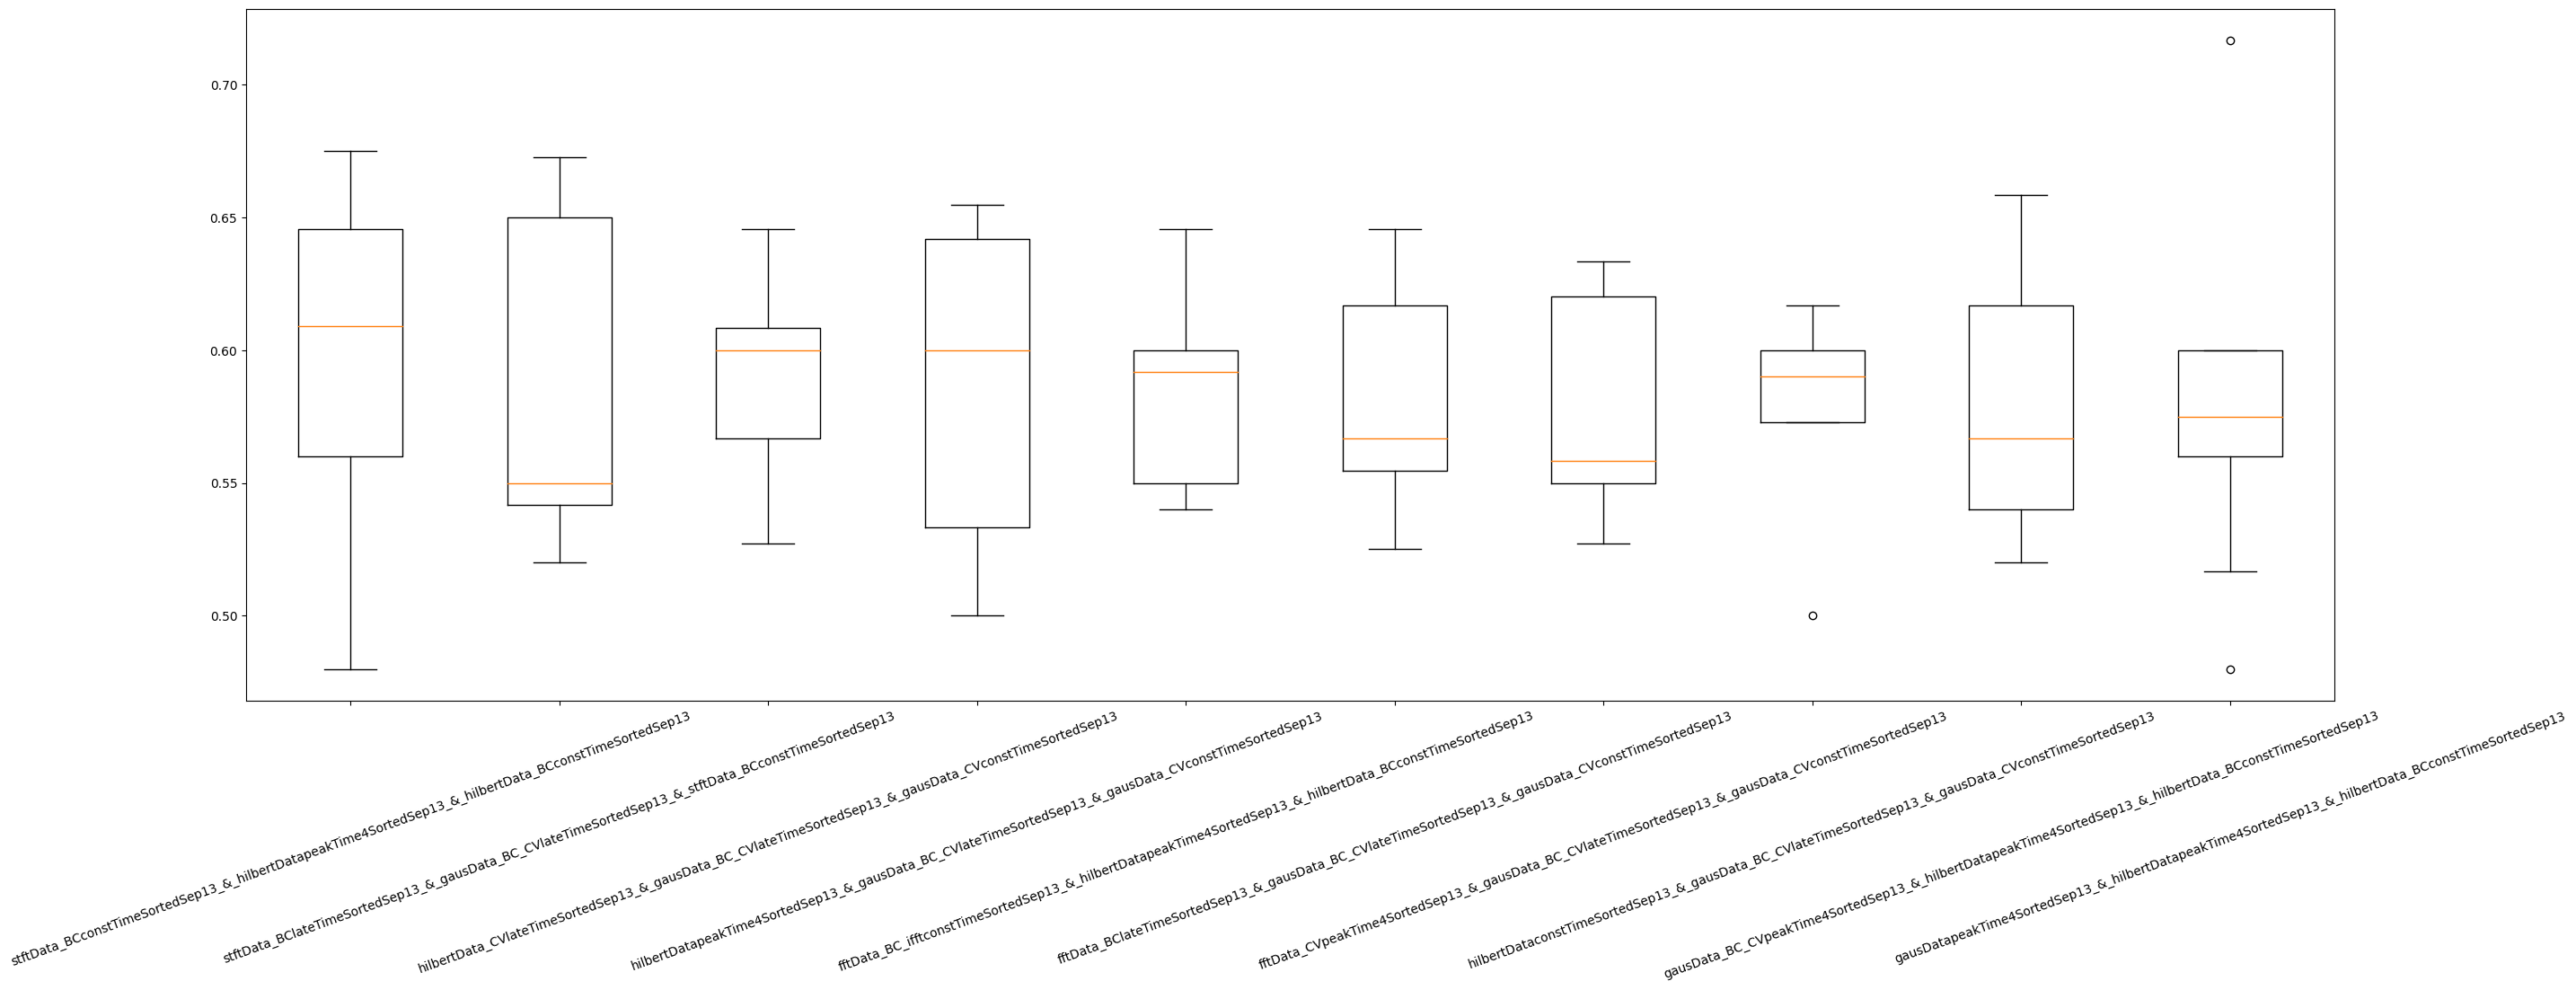

In [804]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=20)
    print("")
    


In [805]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.8 : subject 7, feature:stftData_BClateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelsigmoid, C:2.5
Accuracy 0.79 : subject 7, feature:gausDatapeakTime4SortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelsigmoid, C:2.5
Accuracy 0.78 : subject 7, feature:gausDataconstTimeSortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelsigmoid, C:2.5
Accuracy 0.78 : subject 7, feature:gausData_BClateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelsigmoid, C:2.5
Accuracy 0.78 : subject 7, feature:stftData_BCconstTimeSortedSep13_&_gausData_BClateTimeSortedSep13_&_fftData_BClateTimeSortedSep13, kernelsigmoid, C:2.5
Accuracy 0.78 : subject 7, feature:fftData_CVpeakTime4SortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelsigmoid, C:2.5
Accuracy 0.77 : subject 7, feature:gausData_

In [806]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [807]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )

arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)



Accuracy 0.8 : subject 7, feature:stftData_BClateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelsigmoid, C:2.5

Accuracy 0.75 : subject 2, feature:gausDatalateTimeSortedSep13_&_gausData_BClateTimeSortedSep13_&_fftData_BClateTimeSortedSep13, kernellinear, C:2.5

Accuracy 0.74 : subject 3, feature:fftData_BC_ifftlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13, kernelrbf, C:2.5

Accuracy 0.73 : subject 4, feature:stftData_CVconstTimeSortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13, kernellinear, C:2.5

Accuracy 0.7 : subject 5, feature:hilbertData_CVlateTimeSortedSep13_&_gausData_BC_CVconstTimeSortedSep13_&_hilbertData_BC_CVlateTimeSortedSep13, kernelsigmoid, C:2.5

Accuracy 0.69 : subject 6, feature:fftDatalateTimeSortedSep13_&_stftData_BC_CVpeakTime4SortedSep13_&_gausData_BCconstTimeSortedSep13, kernellinear, C:2.5

Accuracy 0.69 : subject 1, feature:hilbertData_BCpeakT

In [808]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.51266804 0.53726566 0.55460781 0.51296868 0.5372085
 0.51329343 0.55210905 0.46233882 0.4908722 ]


0         1         2         3         4         5         6     \
0  0.003199  0.488855  0.520067  0.549007  0.528721  0.544865  0.504125   

       7         8         9         10        11        12        13    \
0  0.503771  0.513906  0.540875  0.538552  0.527323  0.516566  0.467946   

       14        15        16        17        18        19        20    \
0  0.511246  0.540774  0.518519  0.550606  0.526465  0.504293  0.528013   

       21        22        23        24        25        26        27    \
0  0.507239  0.499226  0.510337  0.548754  0.511566  0.535556  0.554175   

       28        29        30       31        32        33        34    \
0  0.533754  0.551919  0.531582  0.52697  0.535488  0.540034  0.488434   

       35        36        37        38        39        40        41    \
0  0.528788  0.555859  0.541162  0.553923  0.547609  0.539141  0.537946   

       42        43        44        45        46        47       48    \
0  0.533098  0.513199  0.541498  0.541734  0.492104  0.521633  0.53436   

       49        50        51       52        53       54        55    \
0  0.515825  0.534377  0.524141  0.50862  0.520084  0.55101  0.532694   

       56        57        58        59        60        61        62    \
0  0.547155  0.543805  0.489781  0.528468  0.563822  0.541835  0.555438   

       63        64        65        66        67        68        69    \
0  0.550269  0.518215  0.543939  0.517155  0.507054  0.517492  0.531667   

       70        71        72        73        74        75        76    \
0  0.472037  0.518636  0.526667  0.506549  0.527441  0.490859  0.458906   

       77        78        79        80        81        82        83    \
0  0.507744  0.533266  0.518215  0.534024  0.500051  0.468519  0.499933   

      84       85       86        87        88        89        90    \
0  0.53729  0.52138  0.53569  0.514764  0.490337  0.520707  0.518485   

       91        92        93        94        95        96       97    \
0  0.500303  0.519697  0.533872  0.492508  0.519848  0.543822  0.53101   

      98       99       100       101       102      103       104       105   \
0  0.54298  0.51867  0.51968  0.521263  0.552088  0.54096  0.563232  0.496481   

       106       107       108      109       110       111       112   \
0  0.462239  0.521835  0.548283  0.53968  0.550404  0.539916  0.514057   

       113      114       115       116       117       118      119   \
0  0.528687  0.50904  0.503838  0.516902  0.516549  0.489663  0.51404   

       120       121       122       123       124      125       126   \
0  0.552559  0.526667  0.544899  0.509276  0.488872  0.52133  0.528535   

       127       128       129       130       131       132       133   \
0  0.539613  0.537508  0.517845  0.473367  0.525152  0.528333  0.519646   

       134       135       136       137       138       139       140   \
0  0.543653  0.531818  0.502172  0.517492  0.491532  0.487862  0.508165   

     141       142       143       144       145       146       147   \
0  0.5317  0.499731  0.521818  0.544882  0.524731  0.532929  0.546296   

       148       149       150      151       152       153       154   \
0  0.556229  0.537778  0.550505  0.54096  0.545774  0.532172  0.513939   

       155       156       157       158       159       160      161   \
0  0.533047  0.555303  0.518906  0.540404  0.519461  0.520774  0.51899   

       162      163       164       165       166      167       168   \
0  0.536094  0.53303  0.534192  0.544933  0.504899  0.52431  0.529125   

       169       170       171      172       173      174       175   \
0  0.531616  0.536667  0.512542  0.49202  0.510471  0.54468  0.508939   

       176       177       178       179       180       181       182   \
0  0.535657  0.540673  0.499899  0.542088  0.544495  0.546616  0.548468   

       183       184       185       186       187       188       189   \
0  0.524529  0.509158  0.534428  0

Max average accuracy 0.5806734006734007


In [809]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
stftData_BClateTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13
sigmoid
0.5806734006734007

stftData_BCconstTimeSortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13
linear
0.5704377104377104

stftData_BCconstTimeSortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13
sigmoid
0.5696632996632996

hilbertData_BCconstTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_gausData_CVconstTimeSortedSep13
sigmoid
0.5692087542087542

hilbertData_CVlateTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_gausData_CVconstTimeSortedSep13
sigmoid
0.5669865319865319



In [810]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
stftData_BClateTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13
sigmoid
0.5806734006734007

stftData_BCconstTimeSortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13
linear
0.5704377104377104

stftData_BCconstTimeSortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13
sigmoid
0.5696632996632996

hilbertData_BCconstTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_gausData_CVconstTimeSortedSep13
sigmoid
0.5692087542087542

hilbertData_CVlateTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_gausData_CVconstTimeSortedSep13
sigmoid
0.5669865319865319



In [811]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


0         1         2         3         4         5         6     \
0  4.692424  4.399697  4.680606  4.941061  4.758485  4.903788  4.537121   

       7         8         9        10        11        12        13    \
0  4.533939  4.625152  4.867879  4.84697  4.745909  4.649091  4.211515   

       14       15        16        17        18        19        20    \
0  4.601212  4.86697  4.666667  4.955455  4.738182  4.538636  4.752121   

       21       22       23        24        25    26        27        28    \
0  4.565152  4.49303  4.59303  4.938788  4.604091  4.82  4.987576  4.803788   

       29        30        31        32        33        34        35    \
0  4.967273  4.784242  4.742727  4.819394  4.860303  4.395909  4.759091   

       36        37        38        39        40        41        42    \
0  5.002727  4.870455  4.985303  4.928485  4.852273  4.841515  4.797879   

       43        44        45        46        47        48        49    \
0  4.618788  4.873485  4.875606  4.428939  4.694697  4.809242  4.642424   

       50        51        52        53        54        55        56    \
0  4.809394  4.717273  4.577576  4.680758  4.959091  4.794242  4.924394   

       57       58        59        60        61        62        63    \
0  4.894242  4.40803  4.756212  5.074394  4.876515  4.998939  4.952424   

       64        65        66        67        68     69        70    \
0  4.663939  4.895455  4.654394  4.563485  4.657424  4.785  4.248333   

       71    72        73       74        75        76        77        78    \
0  4.667727  4.74  4.558939  4.74697  4.417727  4.130152  4.569697  4.799394   

       79        80        81        82        83        84        85    \
0  4.663939  4.806212  4.500455  4.216667  4.499394  4.835606  4.692424   

       86        87       88        89        90        91        92    \
0  4.821212  4.632879  4.41303  4.686364  4.666364  4.502727  4.677273   

       93        94        95        96        97        98       99    \
0  4.804848  4.432576  4.678636  4.894394  4.779091  4.886818  4.66803   

       100       101       102       103       104       105       106   \
0  4.677121  4.691364  4.968788  4.868636  5.069091  4.468333  4.160152   

       107       108       109       110       111       112       113   \
0  4.696515  4.934545  4.857121  4.953636  4.859242  4.626515  4.758182   

       114       115       116       117      118       119      120   121   \
0  4.581364  4.534545  4.652121  4.648939  4.40697  4.626364  4.97303  4.74   

       122       123       124      125       126       127       128   \
0  4.904091  4.583485  4.399848  4.69197  4.756818  4.856515  4.837576   

       129       130       131    132       133       134       135   \
0  4.660606  4.260303  4.726364  4.755  4.676818  4.892879  4.786364   

       136       137       138       139       140       141       142   \
0  4.519545  4.657424  4.423788  4.390758  4.573485  4.785303  4.497576   

       143       144       145       146       147       148   149       150   \
0  4.696364  4.903939  4.722576  4.796364  4.916667  5.006061  4.84  4.954545   

       151      152       153       154       155       156       157   \
0  4.868636  4.91197  4.789545  4.625455  4.797424  4.997727  4.670152   

       158       159      160       161       162       163       164   \
0  4.863636  4.675152  4.68697  4.670909  4.824848  4.797273  4.807727   

       165       166       167       168       169   170       171       172   \
0  4.904394  4.544091  4.718788  4.762121  4.784545  4.83  4.612879  4.428182   

       173       174       175       176       177       178       179   \
0  4.594242  4.902121  4.580455  4.820909  4.866061  4.499091  4.878788   

       180       181       182       183       184       185       186   \
0  4.900455  4.919545  4.936212  4.720758  4.582424  4.809848  4.616061   

       187   188       189       190       191       192   

1343
9.0
Max total significant accuracy then averaged 0.5806734006734007 
stftData_BClateTimeSortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13
sigmoid
C: 2.5 


In [812]:
for names in featCombos:
    print(names)



fftDatapeakTime4SortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13
fftDatapeakTime4SortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13
fftDatapeakTime4SortedSep13_&_gausData_BClateTimeSortedSep13_&_fftData_BClateTimeSortedSep13
fftDatapeakTime4SortedSep13_&_hilbertDatapeakTime4SortedSep13_&_hilbertData_BCconstTimeSortedSep13
fftDatapeakTime4SortedSep13_&_stftData_BC_CVpeakTime4SortedSep13_&_gausData_BCconstTimeSortedSep13
fftDatapeakTime4SortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_gausData_CVconstTimeSortedSep13
fftDatapeakTime4SortedSep13_&_gausData_BC_CVconstTimeSortedSep13_&_hilbertData_BC_CVlateTimeSortedSep13
fftDatapeakTime4SortedSep13_&_fftData_CVlateTimeSortedSep13_&_gausDatalateTimeSortedSep13
hilbertDatapeakTime4SortedSep13_&_stftData_BCconstTimeSortedSep13_&_gausData_CVpeakTime4SortedSep13
hilbertDatapeakTime4SortedSep13_&_gausData_BC_CVlateTimeSortedSep13_&_stftData_BCconstTimeSortedSep13
hilbertDatapeakTime4S